In [7]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("data/output/df.csv")
processed_df = pd.read_csv("data/output/processed_df.csv")

In [17]:
def recommend_map_knn(level, job, level_range=5):
    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df.dropna(subset=['level', 'spec_filled', 'map'])
    
    # Filter the dataset to use only the data corresponding to the input job
    relevant_data = df_cleaned[(df_cleaned['level'] >= level - level_range) & 
                               (df_cleaned['level'] <= level + level_range) & 
                               (df_cleaned['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Prepare feature matrix (X) for KNN model: 'level', 'spec_filled'
    X = relevant_data[['level', 'spec_filled']].values
    maps_relevant = relevant_data['map'].values

    # KNN Model for finding similar maps based on features
    knn_relevant = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='euclidean')
    knn_relevant.fit(X)

    # Create a feature vector for the input (level, spec_filled)
    input_spec_filled = relevant_data['spec_filled'].mean()  # Use the mean spec_filled value for input
    input_vector = np.array([[level, input_spec_filled]])

    # Find the top 3 nearest neighbors (maps) based on the input features
    distances, indices = knn_relevant.kneighbors(input_vector)
    
    # Get the top 3 map recommendations and their corresponding distances
    recommended_maps = maps_relevant[indices.flatten()]
    recommendation_scores = distances.flatten()

    # Remove duplicate maps if any
    recommended_maps = list(dict.fromkeys(recommended_maps))[:3]  # Limit to 3 unique maps

    # Sort the recommendations by raw distance (lower distance is better)
    sorted_recommendations = sorted(zip(recommended_maps, recommendation_scores), key=lambda x: x[1])

    # Visualize the KNN results
    if isinstance(recommended_maps, list):
        maps = relevant_data['map'].values
        levels = relevant_data['level'].values
        spec_filled = relevant_data['spec_filled'].values
        
        # Plot all data points
        plt.figure(figsize=(8, 6))
        plt.scatter(levels, spec_filled, c='gray', label='Data points', alpha=0.5)

        # Highlight the query point
        plt.scatter(level, input_spec_filled, c='red', label='Query point', s=100, marker='x')

        # Highlight the nearest neighbors
        nearest_neighbors = X[indices.flatten()]
        plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], c='blue', label='Nearest neighbors', s=100, marker='o')

        # Labels and title
        plt.xlabel('Level')
        plt.ylabel('Spec Filled')
        plt.title(f"KNN Visualization for Job: {job} and Level: {level}")
        plt.legend()

        # Show plot
        plt.show()
        
        # Output the recommended maps and their scores (raw distance)
        # Print the similarity scores
        print("Similarity scores for recommended maps:")
        for map_name, score in zip(recommended_maps, recommendation_scores):
            print(f"Map: {map_name}, Score: {score}")
        print("Recommended Maps and Scores:", recommended_maps)

    return sorted_recommendations

# Example usage
# recommended_maps = recommend_map_knn(140, "썬콜", level_range=5)

In [18]:
# Function to get map recommendations based on a given level and job
def recommend_map_svd(level, job, level_range=5):

    # Filter out rows that do not belong to the specified job
    df_job_filtered = df[df['job'] == job]

    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df_job_filtered.dropna(subset=['level', 'job', 'spec_filled', 'map'])
    
    # Calculate map usage frequency for each job
    map_usage_frequency = df_cleaned.groupby(['job', 'map']).size().reset_index(name='usage_count')
    
    # Calculate the total number of interactions for each job
    job_total_count = df_cleaned.groupby('job').size().reset_index(name='total_count')
    
    # Merge the usage count with the total count for each job
    map_usage_frequency = pd.merge(map_usage_frequency, job_total_count, on='job')
    
    # Calculate the percentage usage for each map within each job
    map_usage_frequency['usage_percentage'] = (map_usage_frequency['usage_count'] / map_usage_frequency['total_count']) * 100
    
    # Filter out maps used in less than 5% of the total interactions for each job
    valid_maps_per_job = map_usage_frequency[map_usage_frequency['usage_percentage'] >= 5]
    
    # Now filter the original dataframe to only keep rows with maps that meet the usage threshold
    df_cleaned_filtered = df_cleaned[df_cleaned['map'].isin(valid_maps_per_job['map'])]
    
    # Prepare the data for the recommendation system
    # Create a user-item interaction matrix where rows = users (party_id), columns = maps
    user_map_matrix = df_cleaned_filtered.pivot_table(index='party_id', columns='map', values='spec_filled', aggfunc='mean').fillna(0)
    
    # Apply Matrix Factorization using TruncatedSVD
    svd = TruncatedSVD(n_components=3, random_state=42)  # Using 3 latent factors for this example
    matrix_factorized = svd.fit_transform(user_map_matrix)
    
    # Get the cosine similarity between maps in the reduced space
    map_similarity = cosine_similarity(matrix_factorized.T)

    # Filter data based on the given level and job
    level_range_min = level - level_range
    level_range_max = level + level_range
    relevant_data = df_cleaned_filtered[(df_cleaned_filtered['level'] >= level_range_min) & 
                                       (df_cleaned_filtered['level'] <= level_range_max) & 
                                       (df_cleaned_filtered['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Get the list of maps from the filtered data
    maps_relevant = relevant_data['map'].unique()

    # Ensure that the maps are present in the user_map_matrix
    valid_maps = [map_name for map_name in maps_relevant if map_name in user_map_matrix.columns]
    
    if not valid_maps:
        return "No valid maps available for recommendation."

    # Get the index of relevant maps in the reduced matrix (svd.transform)
    map_indices = [user_map_matrix.columns.get_loc(map_name) for map_name in valid_maps]
    
    # Ensure map_indices do not exceed the range of the reduced matrix (which has 3 factors)
    map_indices = [index for index in map_indices if index < len(map_similarity)]

    # Now calculate similarity scores for each relevant map with all other maps in the reduced matrix
    scores = np.mean(map_similarity[map_indices], axis=0)

    # Sort the scores and get top 3 recommended maps
    recommended_indices = np.argsort(scores)[::-1][:3]
    recommended_maps = user_map_matrix.columns[recommended_indices]
    
    # Visualization of the SVD components and map recommendations
    # Visualize the maps in the SVD space (2D for simplicity)
    plt.figure(figsize=(10, 8))
    
    # Plot all maps in the reduced space (SVD components)
    plt.scatter(matrix_factorized[:, 0], matrix_factorized[:, 1], label="Maps", alpha=0.5, c='gray')
    
    # Highlight the recommended maps in a different color
    for idx in recommended_indices:
        plt.scatter(matrix_factorized[idx, 0], matrix_factorized[idx, 1], label=f"Recommended: {recommended_maps[idx]}", s=100, edgecolors='black')
    
    # Add labels for the recommended maps
    for idx in recommended_indices:
        plt.annotate(recommended_maps[idx], (matrix_factorized[idx, 0], matrix_factorized[idx, 1]), fontsize=12, ha='right', color='black')

    # Labeling and formatting the plot
    plt.title(f"SVD Map Visualization for Job: {job} and Level: {level}")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.legend()
    plt.show()

    # Print the unique maps after preprocessing
    print("Unique maps after preprocessing:")
    print(df_cleaned_filtered['map'].unique())

    # Print the similarity scores
    print("Similarity scores for recommended maps:")
    for map_name, score in zip(recommended_maps, scores[recommended_indices]):
        print(f"Map: {map_name}, Score: {score}")
    
    # Output the recommended maps
    print("Recommended Maps:", recommended_maps)
    # Return the top 3 recommended maps
    return recommended_maps.tolist()

# Example usage
# recommended_maps = recommend_map(140, "썬콜", level_range=5)

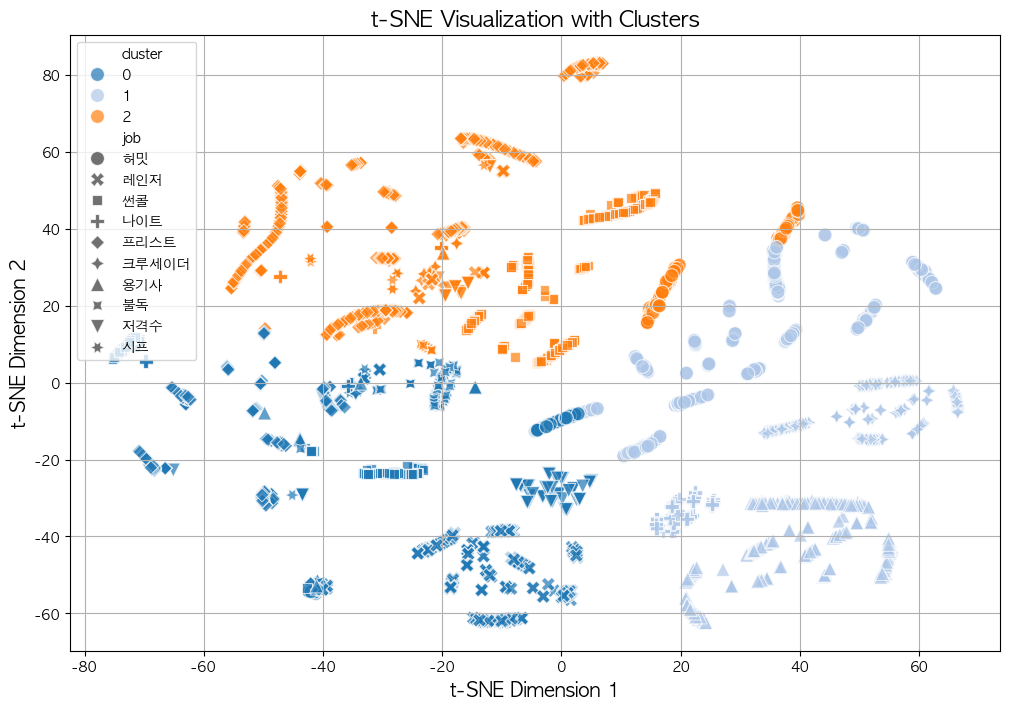

Job-Map combinations in selected cluster (Cluster 0):
       job  map
1      레인저   붉켄
4       썬콜   붉켄
7      나이트   듀파
9     프리스트   듀파
13     레인저   산양
...    ...  ...
3089    허밋   협동
3179    불독   붉켄
3207    불독  망용둥
3259   저격수  불어전
3448    시프   붉켄

[80 rows x 2 columns]
Filtering out levels above the 99.8 percentile: 171.15999999999985
Rows with level >= 171.15999999999985: 3

Rows filtered out based on top level percentile:
      party_id     time  level  job         spec  map        date  valid  \
1233        22  오후 4:34  172.0   불독  1093.220339   협동  2024-12-12   True   
2957       610  오전 1:37  173.0   불독   848.981481   협동  2024-12-16   True   
3059       790  오전 2:10  173.0  레인저  3864.603819  망용둥  2024-12-16   True   

      valid_spec  spec_by_level  avg_spec_by_level  spec_filled  \
1233       False       6.355932           6.355932  1093.220339   
2957       False       4.907407           4.907407   848.981481   
3059       False      22.338750          22.338750  3864.603819   


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

def preprocess_data_for_tsne(df, numerical_features=["level", "spec"], categorical_features=["job", "map"]):
    """
    Preprocesses the data for t-SNE:
    - Encodes categorical features (e.g., job, map).
    - Fills missing values for spec.
    - Normalizes numerical features.
    """
    # Handle missing spec by filling it if NaN (using level * avg_spec_by_level or other features)
    df["spec_filled"] = df.apply(
        lambda row: row["spec"] if pd.notna(row["spec"]) else (
            row["level"] * row["avg_spec_by_level"] if pd.notna(row["level"]) and pd.notna(row["avg_spec_by_level"]) else np.nan
        ),
        axis=1
    )
    
    # Fill missing spec with the filled value (if spec is still NaN)
    df["spec"] = df["spec"].fillna(df["spec_filled"])

    # One-Hot Encode categorical features (e.g., job, map)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_cats = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

    # Normalize numerical features (including spec)
    df[numerical_features] = df[numerical_features].fillna(0)  # Fill NaNs for numerical columns
    scaler = StandardScaler()
    normalized_nums = scaler.fit_transform(df[numerical_features])
    normalized_df = pd.DataFrame(normalized_nums, columns=numerical_features)

    # Combine numerical and categorical features
    combined_df = pd.concat([normalized_df, encoded_df], axis=1)
    return combined_df

def filter_by_tsne(df, perplexity=30, learning_rate=200, n_iter=1000, n_clusters=3):
    """
    Apply t-SNE to the dataset and filter by job-map combinations using K-means clustering.
    """
    # Preprocess the data for t-SNE
    processed_data = preprocess_data_for_tsne(df)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(processed_data)

    # Add t-SNE results to the dataframe
    df["tsne_dim1"] = tsne_results[:, 0]
    df["tsne_dim2"] = tsne_results[:, 1]
    
    # Apply K-means clustering on the t-SNE results to get job-map combinations
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(tsne_results)

    # Visualize the t-SNE results with the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x="tsne_dim1", y="tsne_dim2", hue="cluster", style="job", palette="tab20", s=100, alpha=0.7)
    plt.title("t-SNE Visualization with Clusters", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(True)
    plt.show()

    # Select the job-map combinations (job and map) that belong to specific clusters
    # For now, let’s assume we’re interested in cluster 0 (you can choose any cluster)
    valid_clusters = df[df['cluster'] == 0]  # Filter data that belongs to cluster 0
    
    # Optionally, print the job-map combinations in the selected cluster
    print(f"Job-Map combinations in selected cluster (Cluster 0):")
    print(valid_clusters[['job', 'map']].drop_duplicates())
    
    return valid_clusters

def filter_by_top_level(df, level_percentile=99.8):
    """
    Filter rows by the top `level_percentile` (e.g., top 0.2% of `level`).
    """
    # Calculate the level threshold based on the given percentile
    level_threshold = np.percentile(df["level"], level_percentile)
    print(f"Filtering out levels above the {level_percentile} percentile: {level_threshold}")
    
    # Filter the data based on the threshold
    df_filtered = df[df["level"] >= level_threshold]
    print(f"Rows with level >= {level_threshold}: {len(df_filtered)}")
    
    # Store the filtered rows and return the rest of the data
    filtered_out_data = df[df["level"] >= level_threshold]
    remaining_data = df[df["level"] < level_threshold]
    
    # Print the filtered out rows
    if not filtered_out_data.empty:
        print("\nRows filtered out based on top level percentile:")
        print(filtered_out_data)
    else:
        print("\nNo rows were filtered based on level.")
    
    return remaining_data

def tsne_and_filter(df, level_percentile=99.8, perplexity=30, learning_rate=200, n_iter=1000, n_clusters=3):
    """
    Apply t-SNE for filtering job-map combinations and then filter based on top `level_percentile` for level.
    """
    # Step 1: Filter by job-map combination using t-SNE and clustering (K-means)
    filtered_by_tsne = filter_by_tsne(df, perplexity, learning_rate, n_iter, n_clusters)
    
    # Step 2: Filter by top levels using the specified percentile
    filtered_by_level = filter_by_top_level(filtered_by_tsne, level_percentile)
    
    return filtered_by_level

# Example usage:
# Assuming df is your DataFrame, first apply t-SNE and then filter by level
filtered_df = tsne_and_filter(df, level_percentile=99.8, perplexity=30, learning_rate=200, n_iter=1000, n_clusters=3)

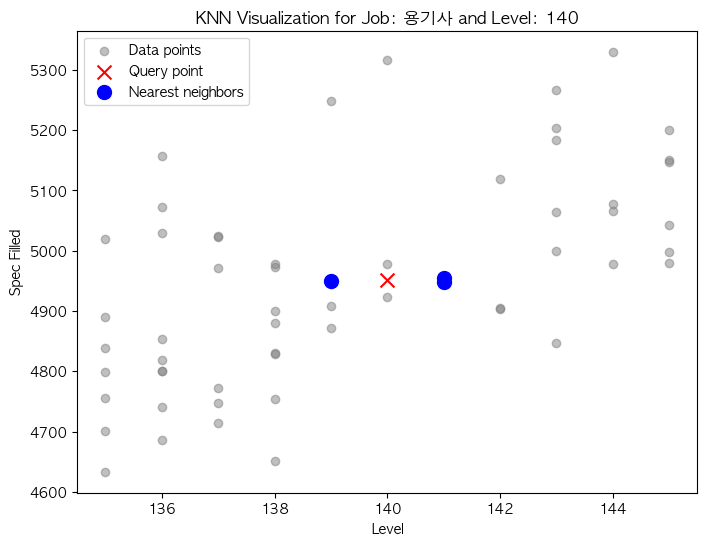

Similarity scores for recommended maps:
Map: 위둥, Score: 1.4527350288051872
Map: 블와둥, Score: 3.1286098117480243
Recommended Maps and Scores: ['위둥', '블와둥']


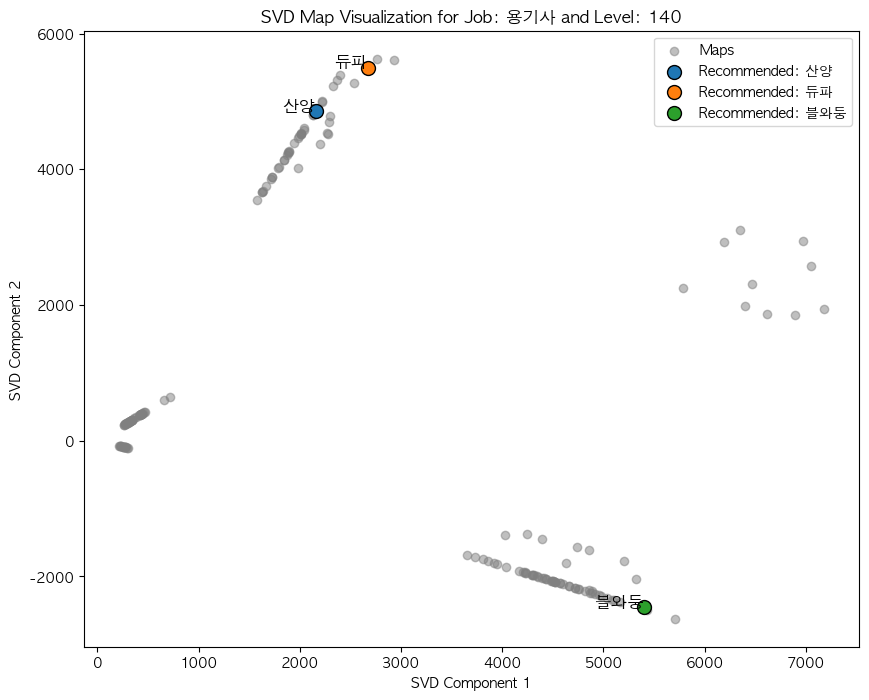

Unique maps after preprocessing:
['하둥' '협동' '블와둥' '산양' '듀파']
Similarity scores for recommended maps:
Map: 블와둥, Score: 0.5000000000000004
Map: 산양, Score: 0.5
Map: 듀파, Score: -1.973247953923618e-16
Recommended Maps: Index(['블와둥', '산양', '듀파'], dtype='object', name='map')
Filtering out levels above the 99 percentile: nan
Filtering out job-map combinations with less than 10.0% population

No rows were filtered out.


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [38]:
recommend_map_knn(140, "용기사", level_range=5)
recommend_map_svd(140, "용기사", level_range=5)
filtered_df = tsne_and_filter(df, level_percentile=99.9, perplexity=30, learning_rate=200, n_iter=1000)

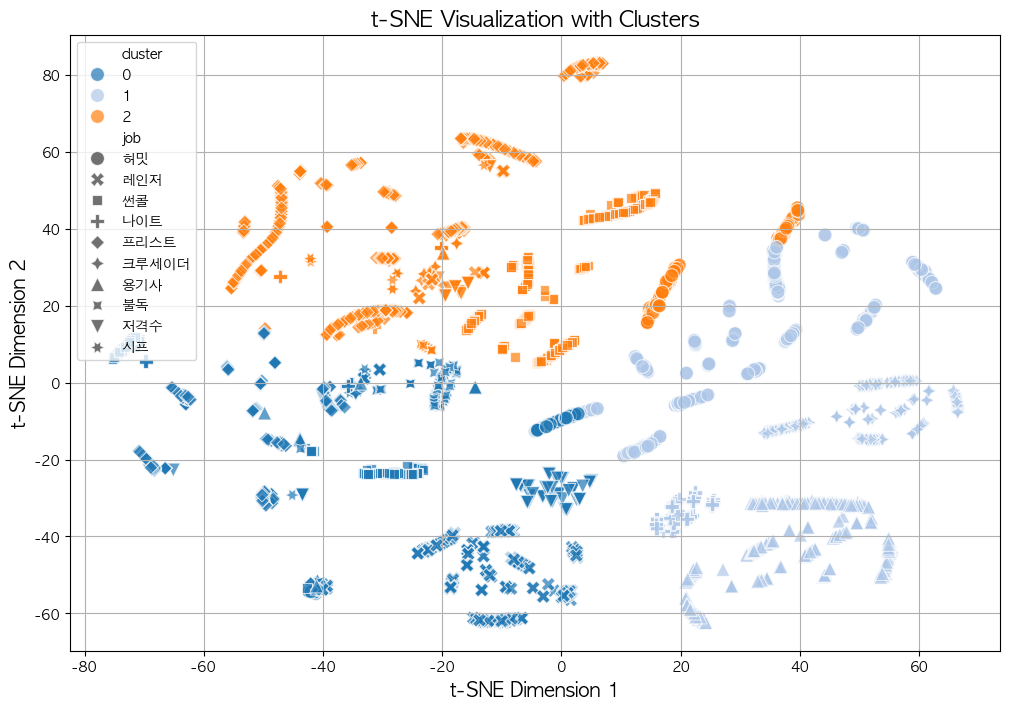

Job-Map combinations in selected cluster (Cluster 0):
       job  map
1      레인저   붉켄
4       썬콜   붉켄
7      나이트   듀파
9     프리스트   듀파
13     레인저   산양
...    ...  ...
3089    허밋   협동
3179    불독   붉켄
3207    불독  망용둥
3259   저격수  불어전
3448    시프   붉켄

[80 rows x 2 columns]
Filtering out levels above the 99.96 percentile: 173.0
Rows with level >= 173.0: 2

Rows filtered out based on top level percentile:
      party_id     time  level  job         spec  map        date  valid  \
2957       610  오전 1:37  173.0   불독   848.981481   협동  2024-12-16   True   
3059       790  오전 2:10  173.0  레인저  3864.603819  망용둥  2024-12-16   True   

      valid_spec  spec_by_level  avg_spec_by_level  spec_filled  \
2957       False       4.907407           4.907407   848.981481   
3059       False      22.338750          22.338750  3864.603819   

      spec_distance  avg_distance_per_job  tsne_dim1  tsne_dim2  cluster  
2957            NaN            525.092593 -18.102129   4.456706        0  
3059            N

In [45]:
filtered_df = tsne_and_filter(df, level_percentile=99.96, perplexity=30, learning_rate=200, n_iter=1000)